In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("LANGCHAIN_API_KEY")
_set_env('LANGCHAIN_TRACING_V2')
_set_env('LANGCHAIN_ENDPOINT')
os.environ["LANGCHAIN_PROJECT"] = "problem_decomposition"

# Test config file
import os
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--model', type = str, default = 'openai')

config = parser.parse_args(args=['--model', 'openai'])


In [2]:
from datasets import load_dataset
# Prep data
# train_set = load_dataset("hotpot_qa", 'distractor', split='train', trust_remote_code=True)
dev_set = load_dataset("hotpot_qa", 'distractor', split = 'validation', trust_remote_code = True)
test_set = dev_set.shuffle(seed = 42) # Use as test set

# Test run

In [3]:
from problem_decomposition import build_graph
from utils import extract_data_info

# Load Graph
# ExperimentName = 'gpt3.5_turbo_test1' # external memory
ExperimentName = 'gpt3.5_turbo_decomposition' 
graph = build_graph(config.model, ExperimentName)

# Run
iteration = 1000

for i in range(iteration):
    data = test_set[i]

    # Extract data info
    unique_id, question, context = extract_data_info(data)

    # Invoke the graphs
    thread = {"configurable": {"thread_id": unique_id}}
    prompt = {
        'messages': question,
        'context': context
    }
    response = graph.invoke(prompt, thread)

In [4]:
# states
import json
# instantiate states
states = {
    'id': [],
    'question': [],
    'answer': [],
    'gt_answer': [],
    'supporting_documents': [],
    'supporting_facts': [],
    'problem': [],
    'sub_problems': [],
    'dependencies': [],
    'sub_problem_solutions': [],
    'sub_problem_reasoning': [],
    'final_reasoning': [],
    'context': []
}

# Get responses
for i in range(iteration):
    # Extract data info
    unique_id = test_set[i]['id']
    gt_answer = test_set[i]['answer']
    supp_facts = test_set[i]['supporting_facts']['title']
    supp_facts_idx = sorted(list(set(
        [
            test_set[i]['context']['title'].index(supp_fact_i) + 1
            for supp_fact_i in supp_facts
        ]
    )))
    
    # load response 
    thread = {"configurable": {"thread_id": unique_id}}
    curr_state = graph.get_state(thread).values
    curr_state['supporting_documents'] = sorted(list(set(curr_state['supporting_documents']))) # convert to set

    # Save state
    for j in states.keys():
        if j in curr_state.keys():
            states[j].append(curr_state[j])
    states['question'].append(curr_state['messages'][0].content)
    states['answer'].append(curr_state['messages'][1].content)
    states['gt_answer'].append(gt_answer)
    states['supporting_facts'].append(supp_facts_idx)
    states['id'].append(unique_id)

json.dump(states, open(f'states/states_{ExperimentName}.json', 'w'), indent = 4)

# Naive

In [7]:
from naive import naive_decomposition, load_naive_prompt
from utils import extract_data_info

# settings
ExperimentName = 'gpt3.5_turbo_naive'
naive_llm = naive_decomposition(config.model)

# Run
iteration = 1000
responses = {'id': [], 'response': []}
for i in range(iteration):
    data = test_set[i]

    # Extract data info
    unique_id, question, context = extract_data_info(data)

    # Invoke the naive llm
    prompt = load_naive_prompt(
        question = question,
        context = context
    )
    response = naive_llm.invoke(prompt)
    responses['response'].append(response)
    responses['id'].append(unique_id)

In [8]:
# states
import json
# instantiate states
states = {
    'id': [],
    'question': [],
    'answer': [],
    'gt_answer': [],
    'supporting_documents': [],
    'supporting_facts': [],
    'context': []
}

# Get responses
for i in range(iteration):
    # Check if the unique_id is the same
    unique_id = test_set[i]['id']
    assert unique_id == responses['id'][i]

    # Extract data info
    question = test_set[i]['question']
    gt_answer = test_set[i]['answer']
    supp_facts = test_set[i]['supporting_facts']['title']
    supp_facts_idx = sorted(list(set(
        [
            test_set[i]['context']['title'].index(supp_fact_i) + 1
            for supp_fact_i in supp_facts
        ]
    )))

    # Extract response
    naive_answer = responses['response'][i].answer
    naive_supporting_docs = sorted(list(set(responses['response'][i].supporting_documents)))

    # Save state
    states['answer'].append(naive_answer)
    states['supporting_documents'].append(naive_supporting_docs)
    states['question'].append(question)
    states['gt_answer'].append(gt_answer)
    states['supporting_facts'].append(supp_facts_idx)
    states['id'].append(unique_id)

json.dump(states, open(f'states/states_{ExperimentName}.json', 'w'), indent = 4)

# Evaluation

In [9]:
from evaluator import HotpotEvaluator

# Instantiate evaluator
evaluator = HotpotEvaluator(openai_key = os.environ["OPENAI_API_KEY"])

# Load states
states = json.load(open(f'states/states_{ExperimentName}.json', 'r'))

# Calculate metrics
results = evaluator.calculate_metrics_answer(states)
results_docs = evaluator.calculate_metrics_supporting_docs(states)

# Save results
json.dump(results, open(f'metrics/metrics_answer_{ExperimentName}.json', 'w'), indent = 4)
json.dump(results_docs, open(f'metrics/metrics_docs_{ExperimentName}.json', 'w'), indent = 4)

In [15]:
results.keys()

dict_keys(['correct', 'incorrect', 'accuracy', 'correctness', 'response', 'exact_matches', 'exact_match_ratio', 'exact_match', 'precision', 'recall', 'f1', 'avg_precision', 'avg_recall', 'avg_f1'])

In [ ]:
# Prompt 3!
results_docs['avg_f1'], results_docs['exact_match_ratio'], results['avg_f1'], results['accuracy']

(0.7557142857142856, 0.45, 0.5159900344715932, 0.75)

In [6]:
# prompt 4
results_docs['avg_f1'], results_docs['exact_match_ratio'], results['avg_f1'], results['accuracy']

(0.7673333333333333, 0.47, 0.3942924825337013, 0.8)

In [6]:
# main problem decomposition
results_docs['avg_f1'], results_docs['exact_match_ratio'], results['avg_f1'], results['accuracy']

(0.7717921356421326, 0.498, 0.35054360623579567, 0.681)

In [ ]:
# Naive test 1
results_docs['avg_f1'], results_docs['exact_match_ratio'], results['avg_f1'], results['accuracy']

(0.7559999999999999, 0.43, 0.7018446439902297, 0.78)

In [10]:
# Naive main
results_docs['avg_f1'], results_docs['exact_match_ratio'], results['avg_f1'], results['accuracy']

(0.7370889610389592, 0.419, 0.5926642276376829, 0.636)

In [13]:
ExperimentName1 = 'gpt3.5_turbo_decomposition'
ExperimentName2 = 'gpt3.5_turbo_naive'

states1 = json.load(open(f'states/states_{ExperimentName1}.json', 'r'))
results1 = json.load(open(f'metrics/metrics_answer_{ExperimentName1}.json', 'r'))
results_docs1 = json.load(open(f'metrics/metrics_docs_{ExperimentName1}.json', 'r'))

states2 = json.load(open(f'states/states_{ExperimentName2}.json', 'r'))
results2 = json.load(open(f'metrics/metrics_answer_{ExperimentName2}.json', 'r'))
results_docs2 = json.load(open(f'metrics/metrics_docs_{ExperimentName2}.json', 'r'))

# print('Custom > Naive')
# for i in range(iteration):
#     if results2['correctness'][i] == 'no' and results1['correctness'][i] == 'yes':
#         gt_answer1 = states1['gt_answer'][i]
#         answer1 = states1['answer'][i]
#         gt_answer2 = states2['gt_answer'][i]
#         answer2 = states2['answer'][i] 
#         print(f'question: {states1["question"][i]}')     
#         print(f'gt: {gt_answer1}')  
#         print(f'problem decomposition: answer = {answer1}')
#         print(f'naive: answer = {answer2}')
#         print()

# print('=====================================')
# print('Custom < Naive')
# for i in range(iteration):
#     if results2['correctness'][i] == 'yes' and results1['correctness'][i] == 'no':
#         gt_answer1 = states1['gt_answer'][i]
#         answer1 = states1['answer'][i]
#         gt_answer2 = states2['gt_answer'][i]
#         answer2 = states2['answer'][i] 
#         print(f'question: {states1["question"][i]}')     
#         print(f'gt: {gt_answer1}')  
#         print(f'problem decomposition: answer = {answer1}')
#         print(f'naive: answer = {answer2}')
#         print()

# print('=====================================')
# print('Custom = Naive')
# for i in range(iteration):
#     if results2['correctness'][i] == 'no' and results1['correctness'][i] == 'no':
#         gt_answer1 = states1['gt_answer'][i]
#         answer1 = states1['answer'][i]
#         gt_answer2 = states2['gt_answer'][i]
#         answer2 = states2['answer'][i] 
#         print(f'question: {states1["question"][i]}')     
#         print(f'gt: {gt_answer1}')  
#         print(f'problem decomposition: answer = {answer1}')
#         print(f'naive: answer = {answer2}')
#         print()                

In [108]:
def plot_comparison(results1, results2, results_docs1, results_docs2, name1="Model 1", name2="Model 2"):
    # Choose color combination
    color1, color2 = '#4A6274', '#94ACBF'    # Soft Blue & Sage Green
    
    # Create figure with horizontal subplot arrangement
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Shared settings
    y_max = 1.0
    label_size = 12
    title_size = 14
    tick_size = 10
    width = 0.35
    
    # Plot 1: Main metrics
    metrics = ['accuracy', 'exact_match_ratio', 'avg_precision', 'avg_recall', 'avg_f1']
    metric_labels = ['ACC', 'EM', 'Precision', 'Recall', 'F1']
    x = np.arange(len(metrics))
    
    # Create bars and add value labels
    values1 = [results1[m] for m in metrics]
    values2 = [results2[m] for m in metrics]
    
    bars1 = ax1.bar(x - width/2, values1, width, color=color1)
    bars2 = ax1.bar(x + width/2, values2, width, color=color2)
    
    # Add value labels above bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:.2f}', ha='center', va='bottom')
    for bar in bars2:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:.2f}', ha='center', va='bottom')
    
    ax1.set_ylabel('Score', fontsize=label_size)
    ax1.set_ylim(0, y_max + 0.1)  # Add padding for labels
    ax1.set_title('Performance Metrics', fontsize=title_size, pad=15)
    ax1.set_xticks(x)
    ax1.set_xticklabels(metric_labels, fontsize=tick_size)
    ax1.tick_params(axis='y', labelsize=tick_size)
    
    # Plot 2: Documents metrics
    doc_metrics = ['exact_match_ratio', 'avg_precision', 'avg_recall', 'avg_f1']
    doc_labels = ['EM', 'Precision', 'Recall', 'F1']
    x2 = np.arange(len(doc_metrics))
    
    # Create bars and add value labels
    values3 = [results_docs1[m] for m in doc_metrics]
    values4 = [results_docs2[m] for m in doc_metrics]
    
    bars3 = ax2.bar(x2 - width/2, values3, width, color=color1)
    bars4 = ax2.bar(x2 + width/2, values4, width, color=color2)
    
    # Add value labels above bars
    for bar in bars3:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:.2f}', ha='center', va='bottom')
    for bar in bars4:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:.2f}', ha='center', va='bottom')
    
    ax2.set_ylabel('Score', fontsize=label_size)
    ax2.set_ylim(0, y_max + 0.1)  # Add padding for labels
    ax2.set_title('Supporting Documents Metrics', fontsize=title_size, pad=15)
    ax2.set_xticks(x2)
    ax2.set_xticklabels(doc_labels, fontsize=tick_size)
    ax2.tick_params(axis='y', labelsize=tick_size)
    
    # Add frameless legend to the figure
    fig.legend([bars1, bars2], [name1, name2], 
              loc='right',
              bbox_to_anchor=(0.18, 0.98),
              frameon=False,
              fontsize=tick_size)
    
    plt.tight_layout()
    plt.show()

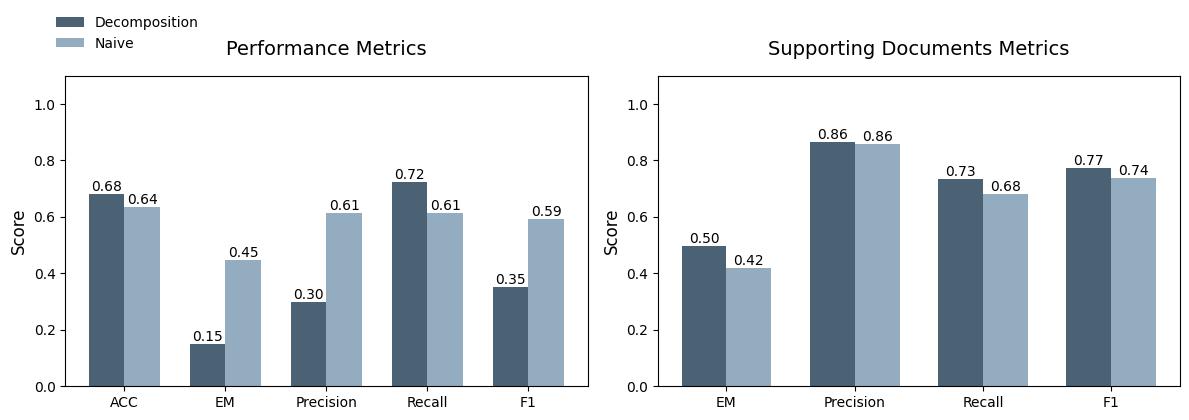

In [109]:
plot_comparison(
    results1, results2, results_docs1, results_docs2, 
    name1="Decomposition", name2="Naive"
)